# Concrete ML Scalability

## Imports

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression as SklearnLR
from sklearn.svm import LinearSVC as SklearnSVC
from sklearn.tree import DecisionTreeClassifier as SklearnDT
from sklearn.ensemble import RandomForestClassifier as SklearnRF
from xgboost.sklearn import XGBClassifier as SklearnXGB
from sklearn.neural_network import MLPClassifier as SklearnNN

from concrete.ml.sklearn import LogisticRegression as ConcreteLR
from concrete.ml.sklearn import LinearSVC as ConcreteSVC
from concrete.ml.sklearn import DecisionTreeClassifier as ConcreteDT
from concrete.ml.sklearn import RandomForestClassifier as ConcreteRF
from concrete.ml.sklearn import XGBClassifier as ConcreteXGB
from concrete.ml.sklearn import NeuralNetClassifier as ConcreteNN

## Create Datasets

In [2]:
# Create a synthetic dataset
observation_sizes = [503]
feature_sizes = [10, 100, 500, 1000]

datasets = []

# Create datasets with different sizes
for n_obs in observation_sizes:
    for n_feat in feature_sizes:
        X, y = make_classification(n_samples=n_obs, n_features=n_feat)
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=3)
        datasets.append((x_train, x_test, y_train, y_test))

## Benchmark

In [3]:
n_bits = 2

classifiers = [
    ('Logistic Regression', SklearnLR, ConcreteLR),
    ('Linear SVC', SklearnSVC, ConcreteSVC),
    ('Decision Tree', SklearnDT, ConcreteDT),
    ('Random Forest', SklearnRF, ConcreteRF),
    ('XGBoost', SklearnXGB, ConcreteXGB),
    ('Neural Network', SklearnNN, ConcreteNN)
]

In [4]:
results = {'Features': [], 'Classifier': [], 'Inference Time (Sklearn)': [], 'Inference Time (Concrete)': []}

for x_train, x_test, y_train, y_test in datasets:

    # Equivalent hyperparameters
    for clf_name, sklearn_clf, concrete_clf in classifiers:
        if sklearn_clf == SklearnNN:
            sklearn_clf = sklearn_clf(hidden_layer_sizes=(x_train.shape[1],))
            concrete_clf = concrete_clf(verbose=0, **{'module__n_layers': 2, 'module__n_hidden_neurons_multiplier': 1, 'module__n_w_bits': n_bits, 'module__n_a_bits': n_bits})
        else:
            sklearn_hyperparams = sklearn_clf().get_params()
            concrete_hyperparams = concrete_clf().get_params()
            shared_hyperparams = {key: concrete_hyperparams[key] for key in sklearn_hyperparams if key in concrete_hyperparams}
            sklearn_clf = sklearn_clf(**shared_hyperparams)
            concrete_clf = concrete_clf(**shared_hyperparams, n_bits=n_bits)

        # Sklearn
        # Initialize classifier
        clf = sklearn_clf
        # Train classifier
        clf.fit(x_train, y_train)
        # Evaluate classifier
        start = time.time()
        clf.predict(x_test)
        end = time.time()
        eval_single_sklearn = (end - start) / x_test.shape[0]

        # Concrete
        # Initialize classifier
        clf = concrete_clf
        # Train classifier
        clf.fit(x_train, y_train)
        # Compile classifier
        clf.compile(x_train)
        # Evaluate classifier
        start = time.time()
        clf.predict(x_test, fhe='execute')
        end = time.time()
        eval_single_concrete = (end - start) / x_test.shape[0]

        # Save results
        results['Features'].append(x_train.shape[1])
        results['Classifier'].append(clf_name)
        results['Inference Time (Sklearn)'].append(eval_single_sklearn)
        results['Inference Time (Concrete)'].append(eval_single_concrete)

# Evaluate

In [5]:
# results to dataframe
df = pd.DataFrame(results)
df_excluding_nn = df[df['Classifier'] != 'Neural Network']

In [6]:
# Calculate how much slower Concrete is compared to Sklearn
df['Concrete Slowdown'] = df['Inference Time (Concrete)'] / df['Inference Time (Sklearn)']
# Calculate the average slowdown for each classifier
df_avg = df.groupby('Classifier')['Concrete Slowdown'].mean().reset_index()
df_avg = df_avg.sort_values('Concrete Slowdown')

In [7]:
df

,Features,Classifier,Inference Time (Sklearn),Inference Time (Concrete),Concrete Slowdown
0,10,LR,0.000051,0.000485,9.562696
1,10,Linear SVC,0.000057,0.000447,7.891854
2,10,DT,0.000044,5.955772,134302.783154
3,10,RF,0.000374,3.145434,8406.694775
4,10,XGBoost,0.011155,1.549823,138.934705
5,10,NN,0.000067,0.803819,12040.938095
6,100,LR,0.000048,0.002585,54.221667
7,100,Linear SVC,0.000074,0.004053,54.902045
8,100,DT,0.000068,3.989965,58446.313155
9,100,RF,0.000340,3.628971,10686.407676


In [8]:
df_avg

,Classifier,Concrete Slowdown
2,Linear SVC,135.266691
1,LR,162.997547
5,XGBoost,629.463227
4,RF,10802.188179
3,NN,37246.207941
0,DT,70719.111332


In [13]:
title_fontsize = 16
ax_fontsize = 11
background_color = '#EAEAF2'
grid_color = 'white'

sns.set_style('whitegrid')

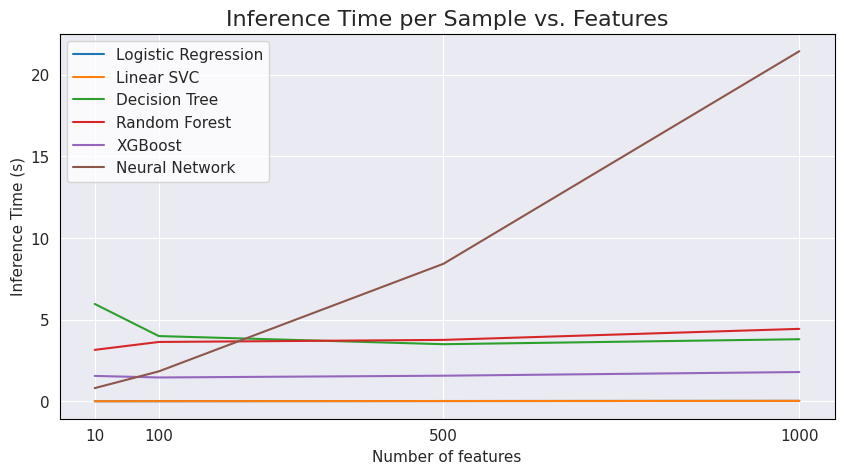

In [17]:
# evaluation time per sample n_feat
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='Features', y='Inference Time (Concrete)', hue='Classifier', ci=None)
plt.xticks(feature_sizes)
plt.xlabel('Number of features', fontsize=ax_fontsize)
plt.ylabel('Inference Time (s)', fontsize=ax_fontsize)
plt.title('Inference Time per Sample vs. Features', fontsize=title_fontsize)
plt.xticks(fontsize=ax_fontsize)
plt.yticks(fontsize=ax_fontsize)
plt.legend(loc='upper left', fontsize=ax_fontsize)
plt.gca().set_facecolor(background_color)
plt.grid(color=grid_color)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.show()

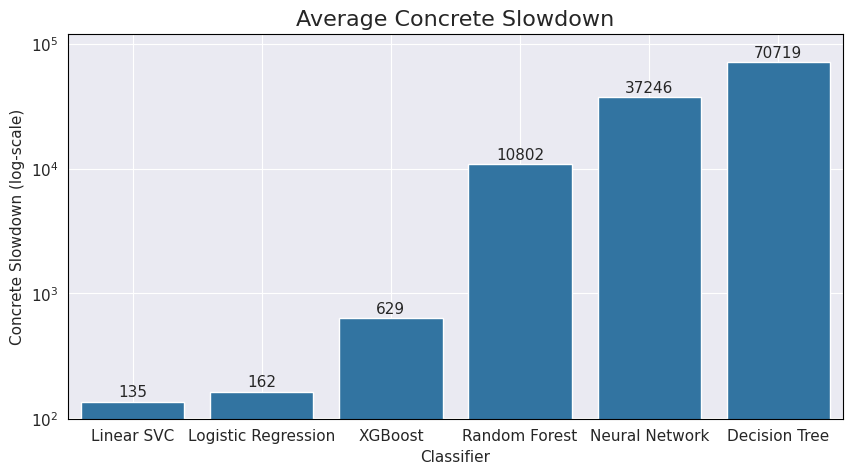

In [27]:
# plot average slowdown
plt.figure(figsize=(10, 5))
sns.barplot(data=df_avg, x='Classifier', y='Concrete Slowdown')
plt.xlabel('Classifier', fontsize=ax_fontsize)
plt.ylabel('Concrete Slowdown (log-scale)', fontsize=ax_fontsize)
plt.title('Average Concrete Slowdown', fontsize=title_fontsize)
plt.xticks(fontsize=ax_fontsize)
plt.yticks(fontsize=ax_fontsize)
plt.gca().set_facecolor(background_color)
# gridlines white
plt.grid(color=grid_color)
plt.yscale('log')
margin = df_avg['Concrete Slowdown'].max()*1.7
plt.ylim(0, margin)
for index, value in enumerate(df_avg['Concrete Slowdown']):
    plt.text(index, value *1.1, int(value), ha='center', fontsize=ax_fontsize)
# black borders
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.show()